# Proyek Klasifikasi Gambar: [Brain Tumor MRI Dataset]
- **Nama:** [Amanda Riyas Utami]
- **Email:** [amandariyas12@gmail.com]
- **ID Dicoding:** [MC223D5X0901]

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle (3).json to kaggle (3).json


{'kaggle (3).json': b'{"username":"amandariyas","key":"b8ed27c290ea0feae0102a04f4aaabb7"}'}

In [4]:
!rm -rf brain_tumor_data/

In [5]:
!ls

'kaggle (3).json'   sample_data


In [6]:
!mv "kaggle (3).json" kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [8]:
import os
import shutil

# Direktori awal untuk train dan test
train_dir = "Training"
test_dir = "Testing"

# Direktori baru untuk dataset gabungan
combined_dir = "BrainTumor_Dataset_Combined"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

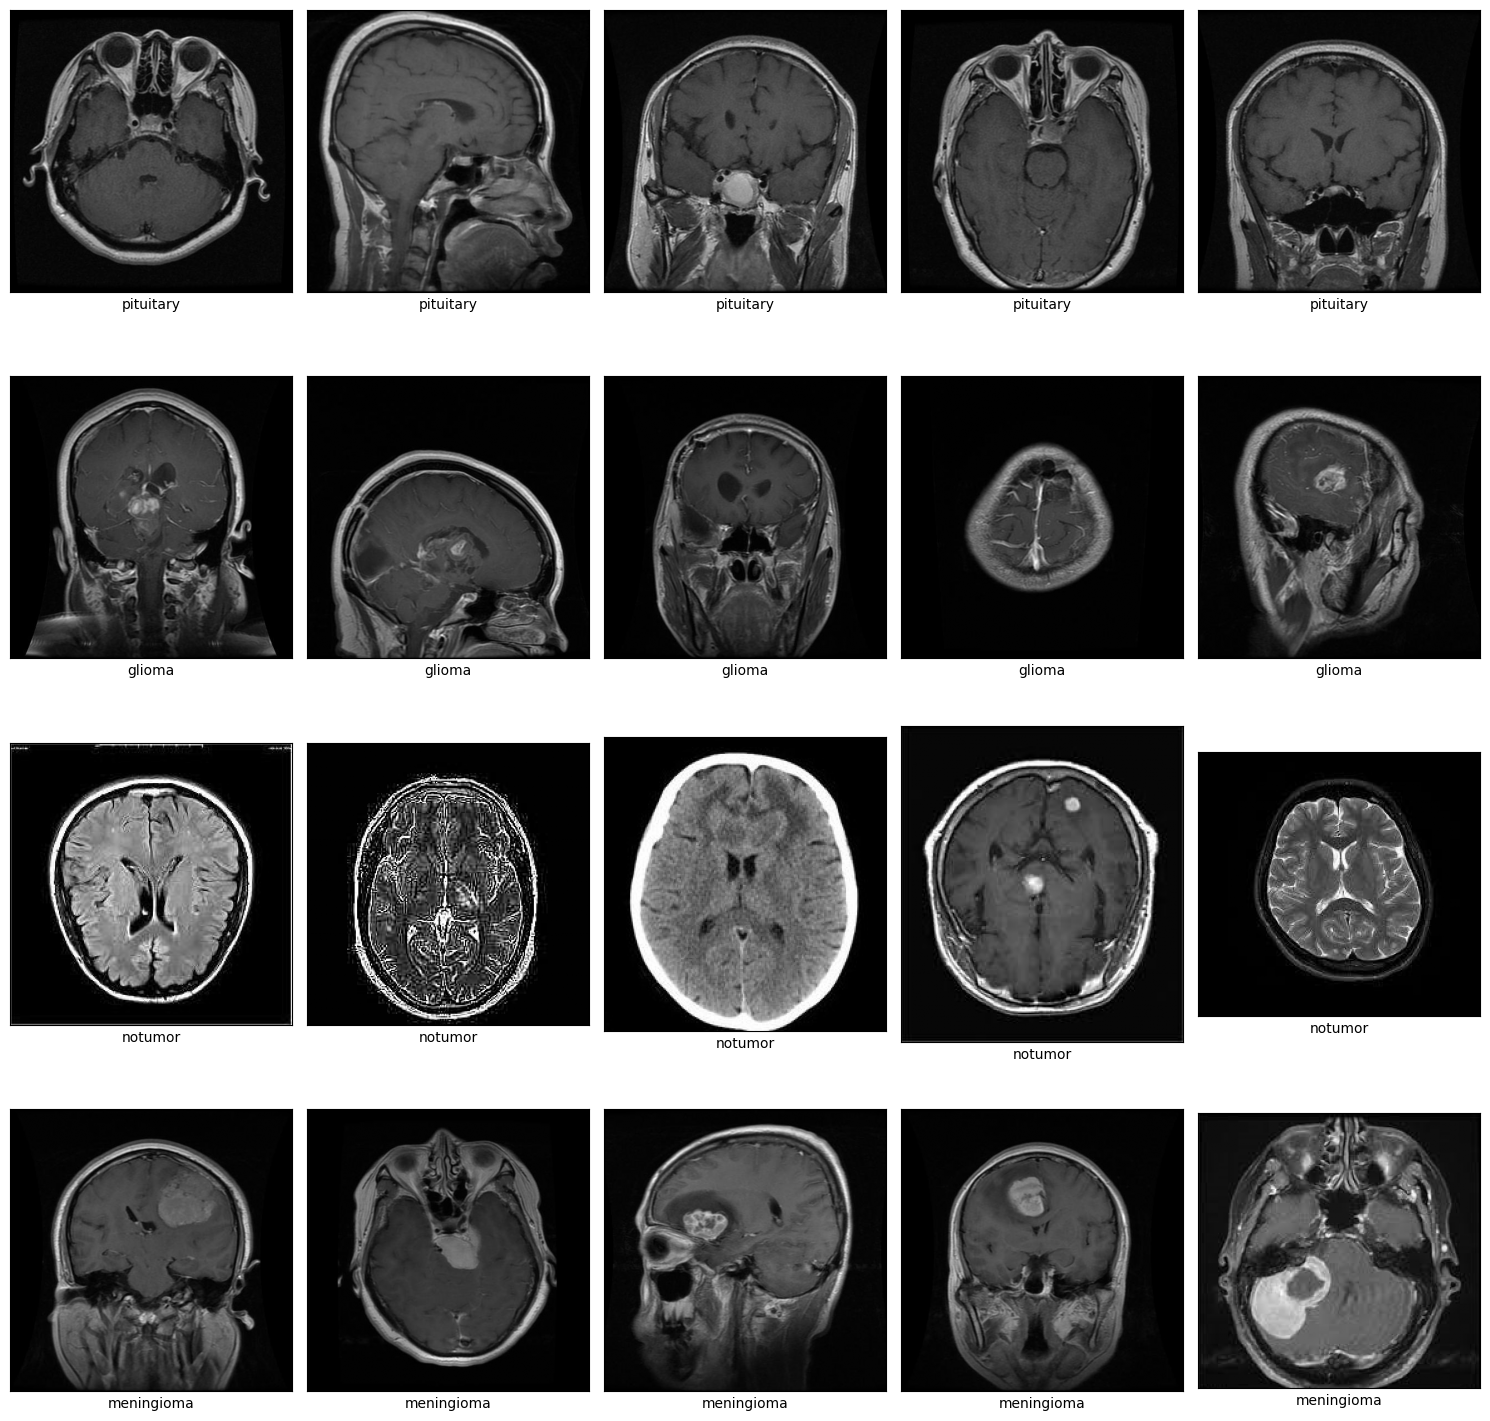

In [9]:
tumor_images = {}

path = "BrainTumor_Dataset_Combined"
path_sub = path

# Membaca gambar-gambar untuk setiap kelas dalam data
for i in os.listdir(path_sub):
    class_path = os.path.join(path_sub, i)
    if os.path.isdir(class_path):
        tumor_images[i] = os.listdir(class_path)

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(tumor_images.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(tumor_images.keys()):
    images = np.random.choice(tumor_images[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()

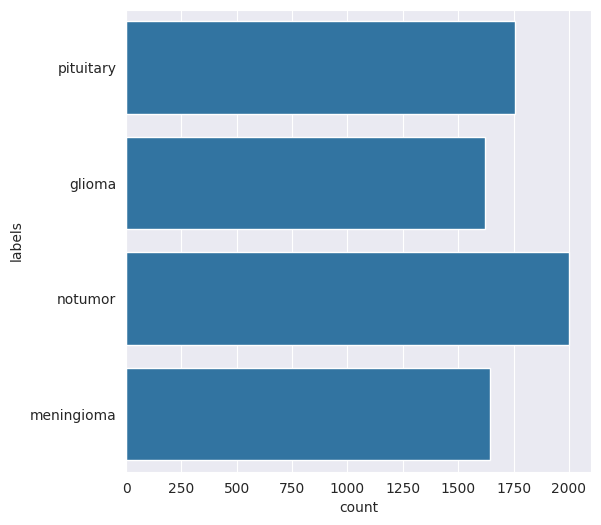

In [10]:
# Define source path
tumor_path = "BrainTumor_Dataset_Combined"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(tumor_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random

# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.random_blur(img, (3, 3))
    return img

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter shearing range
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter width_shift_range dan height_shift_range
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

In [12]:
import random
import cv2
from skimage import io
from skimage import img_as_ubyte

# Fungsi untuk augmentasi gambar (transformasi)
def anticlockwise_rotation(image):
    return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

def clockwise_rotation(image):
    return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

def warp_shift(image):
    # Implementasi warp shift (contoh, kamu bisa menambahkan teknik lainnya)
    rows, cols = image.shape[:2]
    M = np.float32([[1, 0, 50], [0, 1, 50]])  # Shift image
    return cv2.warpAffine(image, M, (cols, rows))

def blur_image(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def add_brightness(image):
    return cv2.convertScaleAbs(image, alpha=1.5, beta=50)

def flip_up_down(image):
    return cv2.flip(image, 0)

def shear_image(image):
    # Contoh shear transformation (bisa disesuaikan)
    rows, cols = image.shape[:2]
    M = np.float32([[1, 0.5, 0], [0.5, 1, 0]])  # Meningkatkan shear
    return cv2.warpAffine(image, M, (cols, rows))

# Mendefinisikan transformasi augmentasi
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': shear_image
}

# Path gambar asli dan path untuk menyimpan gambar augmentasi
images_path = "BrainTumor_Dataset_Combined/notumor"  # Path untuk gambar asli
augmented_path = "BrainTumor_Dataset_Combined/notumor_augmented"  # Path untuk gambar augmentasi

# Membaca nama gambar dari folder dan menambahkan path ke dalam array "images"
images = []
for im in os.listdir(images_path):
    images.append(os.path.join(images_path, im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi
images_to_generate = 2000
i = 1

while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)

        # Memeriksa apakah gambar memiliki dimensi yang valid (3 atau 4 dimensi)
        if original_image.ndim not in [3, 4]:
            raise ValueError('Invalid image dimensions')

        transformed_image = None
        n = 0  # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations))  # Pilih jumlah transformasi acak yang akan diterapkan

        while n < transformation_count:
            key = random.choice(list(transformations))  # Pilih transformasi acak
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path = "%s/augmented_image_%s.jpg" % (augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil gambar augmentasi ke path yang ditentukan
        i = i + 1
    except ValueError as e:
        print('Could not read or process the image', image, ':', e, 'hence skipping it.')

Could not read or process the image BrainTumor_Dataset_Combined/notumor/Tr-no_1001.jpg : Invalid image dimensions hence skipping it.
Could not read or process the image BrainTumor_Dataset_Combined/notumor/Tr-no_1007.jpg : Invalid image dimensions hence skipping it.
Could not read or process the image BrainTumor_Dataset_Combined/notumor/Tr-no_0621.jpg : Invalid image dimensions hence skipping it.
Could not read or process the image BrainTumor_Dataset_Combined/notumor/Tr-no_1143.jpg : Invalid image dimensions hence skipping it.
Could not read or process the image BrainTumor_Dataset_Combined/notumor/Tr-no_0987.jpg : Invalid image dimensions hence skipping it.
Could not read or process the image BrainTumor_Dataset_Combined/notumor/Tr-no_0961.jpg : Invalid image dimensions hence skipping it.
Could not read or process the image BrainTumor_Dataset_Combined/notumor/Tr-no_1449.jpg : Invalid image dimensions hence skipping it.
Could not read or process the image BrainTumor_Dataset_Combined/notum

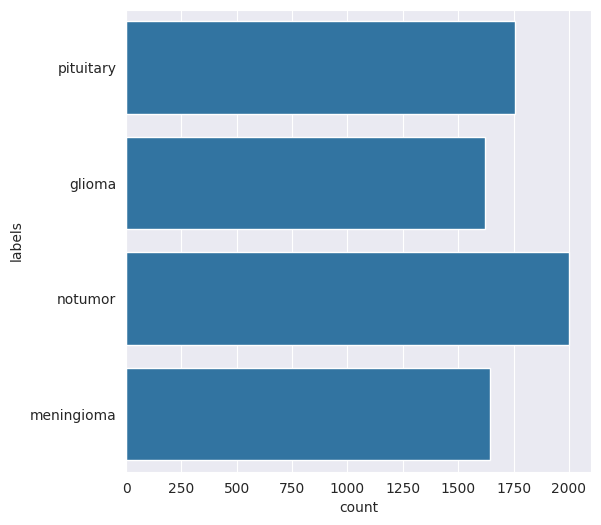

In [13]:
# Define source path
tumor_path = "BrainTumor_Dataset_Combined"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(tumor_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [14]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'BrainTumor_Dataset_Combined'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

,0
labels,
glioma,1621
meningioma,1645
notumor,2000
pituitary,1757


In [15]:
from sklearn.model_selection import train_test_split

X = df['path']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [16]:
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

In [17]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 5618
test size 1405


In [18]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('=================================================================\n')
print(df_all.groupby(['labels', 'set']).size())
print('=================================================================\n')

print(df_all.sample(5))


labels      set  
glioma      test      324
            train    1297
meningioma  test      329
            train    1316
notumor     test      400
            train    1600
pituitary   test      352
            train    1405
dtype: int64

                                                   path      labels    set
4370  BrainTumor_Dataset_Combined/meningioma/Tr-me_0...  meningioma  train
5619  BrainTumor_Dataset_Combined/meningioma/Tr-me_0...  meningioma   test
2543  BrainTumor_Dataset_Combined/pituitary/Tr-pi_07...   pituitary  train
5761  BrainTumor_Dataset_Combined/notumor/Tr-no_0529...     notumor   test
6814  BrainTumor_Dataset_Combined/glioma/Tr-gl_0528.jpg      glioma   test


In [19]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "BrainTumor_Dataset_Combined"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [20]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [21]:
# Image Data Generator
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

for cls in classes:
    train_path = os.path.join(TRAIN_DIR, cls)
    test_path = os.path.join(TEST_DIR, cls)

    print(f"Total number of {cls.upper()} images in training set   : {len(os.listdir(train_path))}")
    print(f"Total number of {cls.upper()} images in test set       : {len(os.listdir(test_path))}")

Total number of GLIOMA images in training set   : 1297
Total number of GLIOMA images in test set       : 324
Total number of MENINGIOMA images in training set   : 1316
Total number of MENINGIOMA images in test set       : 329
Total number of NOTUMOR images in training set   : 1600
Total number of NOTUMOR images in test set       : 400
Total number of PITUITARY images in training set   : 1405
Total number of PITUITARY images in test set       : 352


In [22]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(150, 150),
    color_mode="grayscale",
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(150, 150),
    color_mode="grayscale",
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(150, 150),
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=False
)


Found 4495 images belonging to 4 classes.
Found 1123 images belonging to 4 classes.
Found 1405 images belonging to 4 classes.


## Modelling

# Model Exp 1 - CNN Architecture (Using 32 Neurons in Conv Layer):

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import tensorflow as tf

# Inisialisasi model
model_1 = Sequential()

# 1st Convolutional layer, Batch Normalization, and Pooling
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization, and Pooling
model_1.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization, and Pooling
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D((2, 2)))

# Flatten sebelum Fully Connected
model_1.add(Flatten())

# Fully Connected Layers
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.3))

# Output layer: 4 kelas pakai softmax
model_1.add(Dense(4, activation='softmax'))

# Compile model (karena multiclass, pakai categorical_crossentropy)
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,076 (5.35 MB)

 Trainable params: 1,402,884 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

In [24]:
print("GPU:", tf.config.list_physical_devices('GPU'))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [25]:
import os
from tensorflow.keras.callbacks import EarlyStopping

# Menghitung jumlah gambar per kelas di TRAIN_DIR
count_glioma = len(os.listdir(os.path.join(TRAIN_DIR, 'glioma')))
count_meningioma = len(os.listdir(os.path.join(TRAIN_DIR, 'meningioma')))
count_pituitary = len(os.listdir(os.path.join(TRAIN_DIR, 'pituitary')))
count_notumor = len(os.listdir(os.path.join(TRAIN_DIR, 'notumor')))

# Menghitung total gambar
total_images = count_glioma + count_meningioma + count_pituitary + count_notumor

# Menghitung class_weights berdasarkan jumlah gambar
weight_0 = (1 / count_glioma) * (total_images) / 4.0
weight_1 = (1 / count_meningioma) * (total_images) / 4.0
weight_2 = (1 / count_pituitary) * (total_images) / 4.0
weight_3 = (1 / count_notumor) * (total_images) / 4.0

# Menyusun dictionary class_weights
class_weights = {0: weight_0, 1: weight_1, 2: weight_2, 3: weight_3}

# Menyusun model dengan Adam optimizer
model_1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_1 = model_1.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 120ms/step - accuracy: 0.5034 - loss: 1.8244 - val_accuracy: 0.2102 - val_loss: 1.8216
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.6518 - loss: 0.9202 - val_accuracy: 0.2760 - val_loss: 2.3099
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.6643 - loss: 0.8525 - val_accuracy: 0.3197 - val_loss: 1.4620
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.7133 - loss: 0.6923 - val_accuracy: 0.7142 - val_loss: 0.6267
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.7758 - loss: 0.6098 - val_accuracy: 0.7542 - val_loss: 0.6611
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.7628 - loss: 0.6359 - val_accuracy: 0.8023 - val_loss: 0.4772
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.7934 - loss: 0.5328 - val_accuracy: 0.8014 - val_loss: 0.4375
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.8340 - loss: 0.4561 - val_accuracy: 0

# Model Exp 2 - CNN Architecture (Using 64 Neurons in Conv Layer):

In [26]:
# Inisialisasi model
model_2 = Sequential()

# 1st Convolutional layer, Batch Normalization, and Pooling (64 filters)
model_2.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization, and Pooling (64 filters)
model_2.add(Conv2D(64, (4, 4), padding='same', activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization, and Pooling (64 filters)
model_2.add(Conv2D(64, (7, 7), padding='same', activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))

# Flatten sebelum Fully Connected
model_2.add(Flatten())

# Fully Connected Layers
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.3))

# Output layer: 4 kelas pakai softmax
model_2.add(Dense(4, activation='softmax'))

# Compile model (karena multiclass, pakai categorical_crossentropy)
model_2.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 64)     │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,930,628 (11.18 MB)

 Trainable params: 2,930,244 (11.18 MB)

 Non-trainable params: 384 (1.50 KB)

In [27]:
# Menghitung jumlah gambar per kelas di TRAIN_DIR
count_glioma = len(os.listdir(os.path.join(TRAIN_DIR, 'glioma')))
count_meningioma = len(os.listdir(os.path.join(TRAIN_DIR, 'meningioma')))
count_pituitary = len(os.listdir(os.path.join(TRAIN_DIR, 'pituitary')))
count_notumor = len(os.listdir(os.path.join(TRAIN_DIR, 'notumor')))

# Menghitung total gambar
total_images = count_glioma + count_meningioma + count_pituitary + count_notumor

# Menghitung class_weights berdasarkan jumlah gambar
weight_0 = (1 / count_glioma) * (total_images) / 4.0
weight_1 = (1 / count_meningioma) * (total_images) / 4.0
weight_2 = (1 / count_pituitary) * (total_images) / 4.0
weight_3 = (1 / count_notumor) * (total_images) / 4.0

# Menyusun dictionary class_weights
class_weights = {0: weight_0, 1: weight_1, 2: weight_2, 3: weight_3}

# Menyusun model dengan Adam optimizer
model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_2 = model_2.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 25s 114ms/step - accuracy: 0.4681 - loss: 2.6212 - val_accuracy: 0.2538 - val_loss: 3.4293
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.4977 - loss: 1.2506 - val_accuracy: 0.2529 - val_loss: 1.9407
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.5523 - loss: 1.0898 - val_accuracy: 0.3767 - val_loss: 1.4207
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.5806 - loss: 0.9997 - val_accuracy: 0.6296 - val_loss: 0.9137
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.6021 - loss: 0.9340 - val_accuracy: 0.6661 - val_loss: 0.8364
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.6195 - loss: 0.9277 - val_accuracy: 0.7159 - val_loss: 0.7372
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.6330 - loss: 0.8620 - val_accuracy: 0.7284 - val_loss: 0.6758
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.6545 - loss: 0.8262 - v

# Model Exp 3 - CNN Architecture (Using 128 Neurons in Conv Layer):

In [28]:
# Inisialisasi model
model_3 = Sequential()

# 1st Convolutional layer, Batch Normalization, and Pooling (128 filters)
model_3.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization, and Pooling (128 filters)
model_3.add(Conv2D(128, (4, 4), padding='same', activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization, and Pooling (128 filters)
model_3.add(Conv2D(128, (7, 7), padding='same', activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

# Flatten sebelum Fully Connected
model_3.add(Flatten())

# Fully Connected Layers
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dropout(0.3))

# Output layer: 4 kelas pakai softmax
model_3.add(Dense(4, activation='softmax'))

# Compile model (karena multiclass, pakai categorical_crossentropy)
model_3.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 150, 150, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 75, 75, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 37, 37, 128)    │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,385,092 (24.36 MB)

 Trainable params: 6,384,324 (24.35 MB)

 Non-trainable params: 768 (3.00 KB)

In [29]:
# Menghitung jumlah gambar per kelas di TRAIN_DIR
count_glioma = len(os.listdir(os.path.join(TRAIN_DIR, 'glioma')))
count_meningioma = len(os.listdir(os.path.join(TRAIN_DIR, 'meningioma')))
count_pituitary = len(os.listdir(os.path.join(TRAIN_DIR, 'pituitary')))
count_notumor = len(os.listdir(os.path.join(TRAIN_DIR, 'notumor')))

# Menghitung total gambar
total_images = count_glioma + count_meningioma + count_pituitary + count_notumor

# Menghitung class_weights berdasarkan jumlah gambar
weight_0 = (1 / count_glioma) * (total_images) / 4.0
weight_1 = (1 / count_meningioma) * (total_images) / 4.0
weight_2 = (1 / count_pituitary) * (total_images) / 4.0
weight_3 = (1 / count_notumor) * (total_images) / 4.0

# Menyusun dictionary class_weights
class_weights = {0: weight_0, 1: weight_1, 2: weight_2, 3: weight_3}

# Menyusun model dengan Adam optimizer
model_3.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_3 = model_3.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 201ms/step - accuracy: 0.4130 - loss: 3.3791 - val_accuracy: 0.2769 - val_loss: 12.8392
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.3762 - loss: 1.3663 - val_accuracy: 0.2716 - val_loss: 1.6682
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.3088 - loss: 1.3053 - val_accuracy: 0.2680 - val_loss: 1.8353
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.3492 - loss: 1.3185 - val_accuracy: 0.3188 - val_loss: 1.3605
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.3256 - loss: 1.3321 - val_accuracy: 0.3170 - val_loss: 1.2787
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.3433 - loss: 1.3484 - val_accuracy: 0.3624 - val_loss: 1.6764
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - accuracy: 0.3360 - loss: 1.3484 - val_accuracy: 0.2538 - val_loss: 1.4197
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.3408 - loss: 

## Evaluasi dan Visualisasi

# Evaluasi Model Exp 1 - CNN Architecture (Using 32 Neurons in Conv Layer):

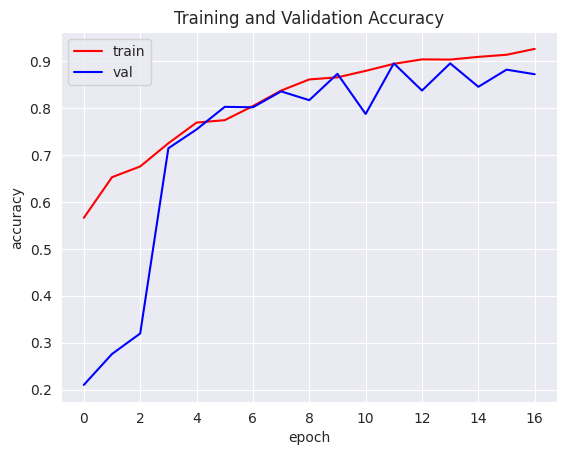

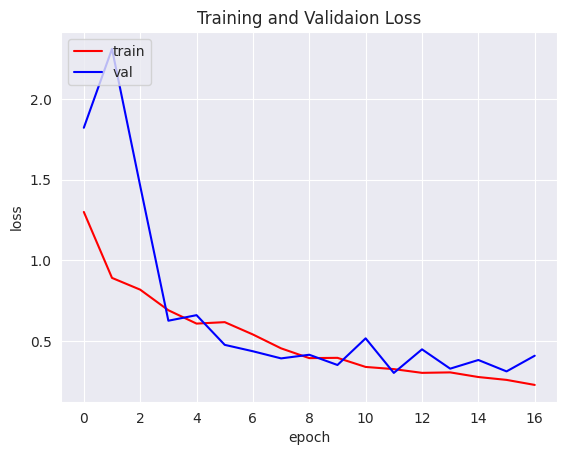

In [30]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

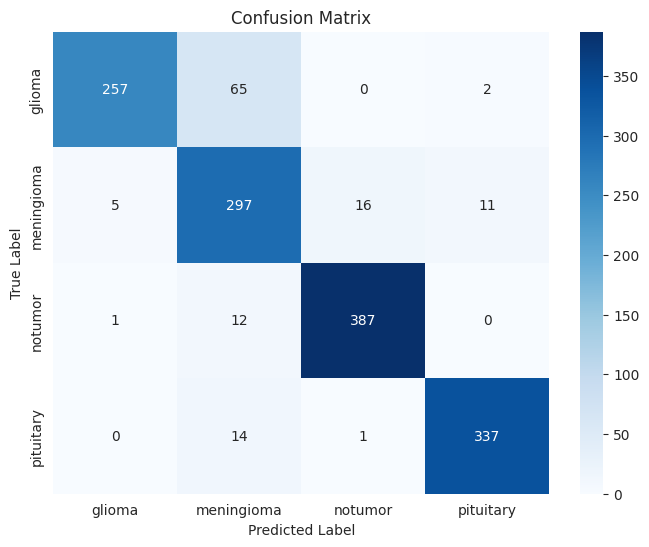


Classification Report:

              precision    recall  f1-score   support

      glioma     0.9772    0.7932    0.8756       324
  meningioma     0.7655    0.9027    0.8285       329
     notumor     0.9579    0.9675    0.9627       400
   pituitary     0.9629    0.9574    0.9601       352

    accuracy                         0.9096      1405
   macro avg     0.9159    0.9052    0.9067      1405
weighted avg     0.9185    0.9096    0.9105      1405



In [31]:
test_generator.reset()
preds_1 = model_1.predict(test_generator, verbose=0)
y_pred = np.argmax(preds_1, axis=1)

from sklearn.metrics import confusion_matrix, classification_report

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(test_generator.classes, y_pred, target_names=class_names, digits=4))

# Evaluasi Model Exp 2 - CNN Architecture (Using 64 Neurons in Conv Layer):

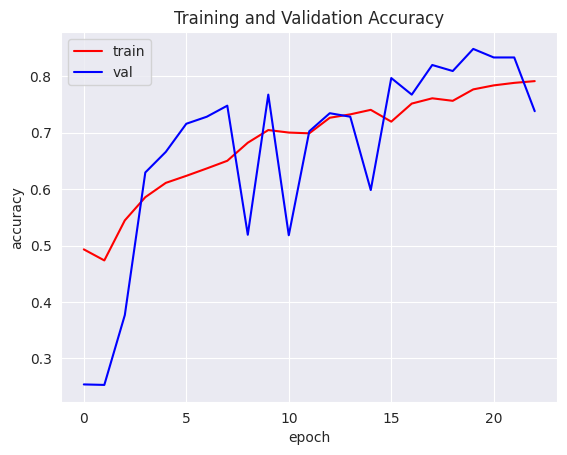

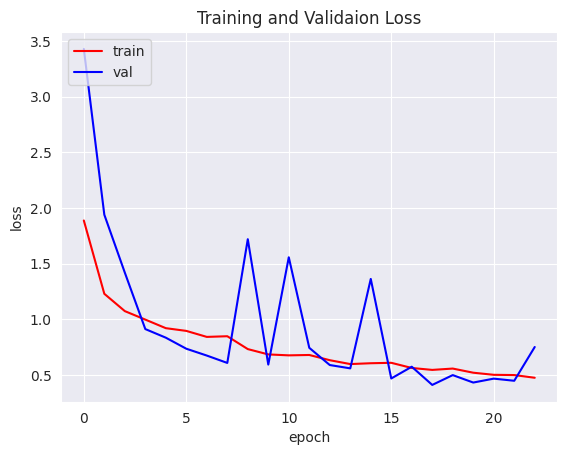

In [32]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

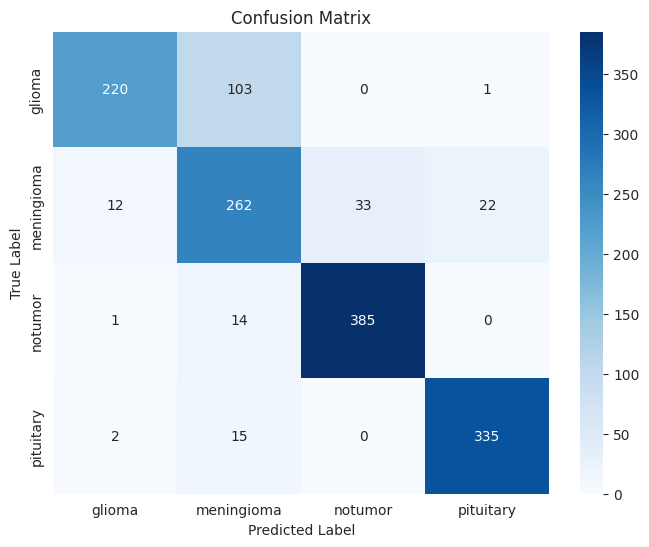


Classification Report:

              precision    recall  f1-score   support

      glioma     0.9362    0.6790    0.7871       324
  meningioma     0.6650    0.7964    0.7248       329
     notumor     0.9211    0.9625    0.9413       400
   pituitary     0.9358    0.9517    0.9437       352

    accuracy                         0.8555      1405
   macro avg     0.8645    0.8474    0.8492      1405
weighted avg     0.8683    0.8555    0.8556      1405



In [33]:
test_generator.reset()
preds_2 = model_2.predict(test_generator, verbose=0)
y_pred = np.argmax(preds_2, axis=1)

from sklearn.metrics import confusion_matrix, classification_report

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(test_generator.classes, y_pred, target_names=class_names, digits=4))

# Evaluasi Model Exp 3 - CNN Architecture (Using 128 Neurons in Conv Layer):

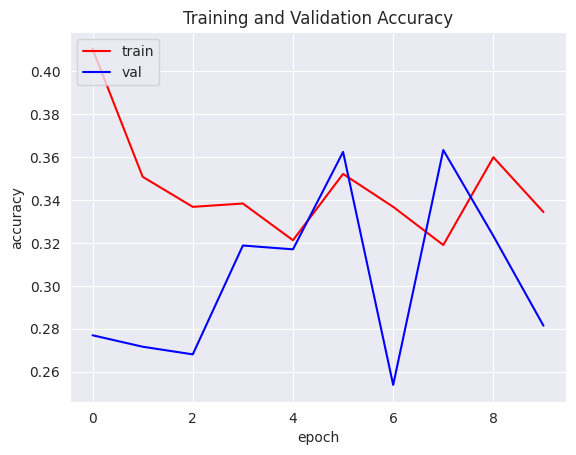

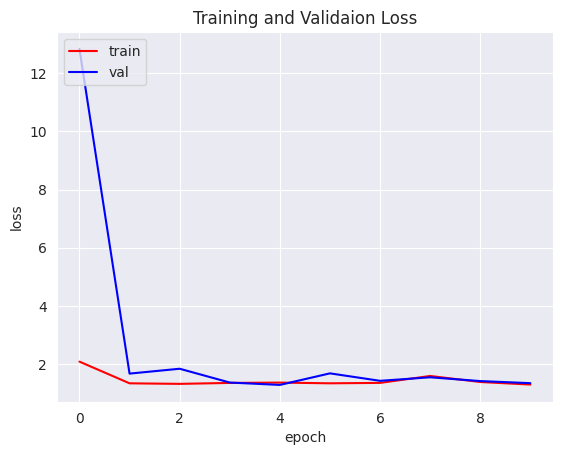

In [34]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

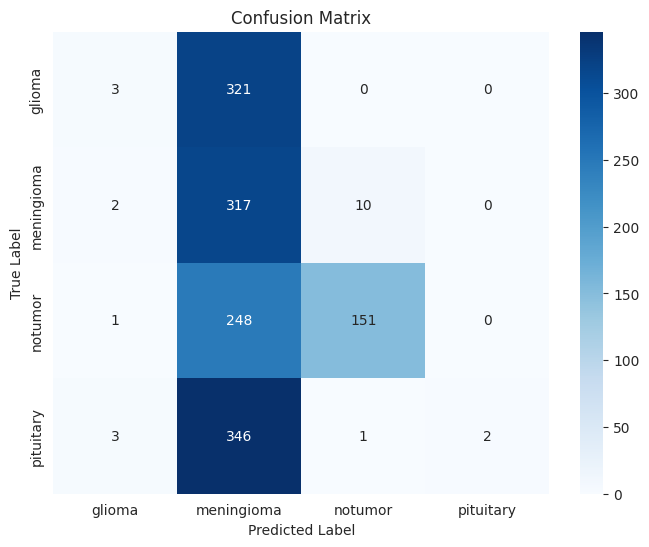


Classification Report:

              precision    recall  f1-score   support

      glioma     0.3333    0.0093    0.0180       324
  meningioma     0.2573    0.9635    0.4061       329
     notumor     0.9321    0.3775    0.5374       400
   pituitary     1.0000    0.0057    0.0113       352

    accuracy                         0.3367      1405
   macro avg     0.6307    0.3390    0.2432      1405
weighted avg     0.6530    0.3367    0.2551      1405



In [35]:
test_generator.reset()
preds_3 = model_3.predict(test_generator, verbose=0)
y_pred = np.argmax(preds_3, axis=1)

from sklearn.metrics import confusion_matrix, classification_report

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(test_generator.classes, y_pred, target_names=class_names, digits=4))

Kesimpulan:\
Model 1 memiliki akurasi, precision, recall, f1-score yang lebih baik diantara metode yang lain sehingga model 1 adalah model yang layak untuk dikonversi

## Konversi Model

In [41]:
model_1.save("model_1.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [42]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [44]:
!tensorflowjs_converter --input_format=keras model_1.keras tfjs_model

2025-04-26 06:28:33.417870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745648913.439365    7900 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745648913.445422    7900 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
             ^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib

In [45]:
model_1.save("model_1.h5")

In [47]:
!tensorflowjs_converter --input_format=keras model_1.h5 tfjs_model

2025-04-26 06:31:48.286504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745649108.307788    8730 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745649108.314654    8730 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [48]:
import numpy as np

X_dummy = np.random.rand(10, 32)
y_dummy = np.random.randint(0, 10, size=(10,))

model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model_1.fit(X_dummy, y_dummy, epochs=1)

model_1.save("model_1.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 5.4561


In [50]:
!tensorflowjs_converter --input_format=keras model_1.h5 tfjs_model

2025-04-26 06:36:09.011839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745649369.031781    9832 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745649369.037933    9832 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [51]:
model = tf.keras.models.load_model("model_1.h5")

# Convert model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file .tflite
with open("model_1.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpuh31y5by'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132397238151760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132397238148112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132397238150224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132397238148304: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [52]:
os.makedirs("tflite", exist_ok=True)

# Simpan label ke dalam file
with open("tflite/label.txt", "w") as f:
    for label in class_names:
        f.write(label + "\n")

In [54]:
model_1.export("saved_model")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32), dtype=tf.float32, name='keras_tensor_363')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132397238152144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132397238153680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132397238151568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132397238154064: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [56]:
from tensorflow.keras.layers import TFSMLayer

# Memuat model SavedModel
loaded_model = tf.keras.Sequential([
    TFSMLayer("saved_model", call_endpoint="serving_default")
])

## Inference (Optional)

In [58]:
import tensorflow as tf
import numpy as np

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="model_1.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
input_data = np.random.rand(*input_shape).astype(np.float32)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print("Output prediksi:", output_data)

Output prediksi: [[-0.7139765   0.7491348  -0.39651024  0.76939553  0.34304842 -0.69292325
  -0.10551088  0.14804915 -0.44871083 -0.41539454]]


In [60]:
pip freeze > requirements.txt